# Lista 3

In [1]:
import sys
sys.path.append('..')

from IPython.display import display, HTML, Math

import numpy as np
from numpy.typing import ArrayLike
from scipy.optimize import minimize
from scipy.stats import chi2, t, f, norm, poisson
from jax import hessian, numpy as jnp, jacfwd
from jax.scipy.stats.norm import logpdf as norm_logpdf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from utils.math import normalize, hdi

Para calcular médias e variâncias amostrais e seus respectivos intervalos de confiança, implementamos a classe `IIDSamples` abaixo.

In [2]:
class IIDSamples:
    def __init__(self, arr: ArrayLike, mu=None, sigma=None) -> None:
        self.arr = np.asarray(arr)
        self.n = arr.size
        self.mu = mu
        self.sigma = sigma

        self.known_mu = mu is not None
        self.known_sigma = sigma is not None

    @property
    def sample_mean(self):
        return np.mean(self.arr)
    
    @property
    def _mean(self):
        return self.mu if self.known_mu else self.sample_mean
    
    @property
    def sample_variance(self):
        deg = self.n if self.known_mu else self.n - 1.
        return np.sum((self.arr - self._mean) ** 2) / deg

    @property
    def _sigma(self):
        return self.sigma if self.known_sigma else np.sqrt(self.sample_variance)

    def mean_confidence_interval(self, alpha):
        dist = norm() if self.known_sigma else t(self.n - 1)
        scatter = dist.ppf(0.5 + 0.5 * alpha) * self._sigma / np.sqrt(self.n)
        return self.sample_mean + scatter * np.array([-1, 1])

    def variance_confidence_interval(self, alpha):
        dist = chi2(self.n - 1)
        quantiles = dist.ppf(0.5 * np.array([1.0 + alpha, 1.0 - alpha]))
        return (self.n - 1.0) * self.sample_variance / quantiles

## Questão 1

### 6.1)

In [3]:
data = np.asarray([0.753, 3.795, 4.827, 2.025])
samples = IIDSamples(data)
var = samples.sample_variance
std_dev = np.sqrt(var)
display(Math(f'S^2 = {var:.2f}'))
display(Math(f'S = {std_dev:.2f}'))
display(Math('\\text{Standard eror of the sample mean is }' + f'{np.sqrt(var / samples.n):.2f}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### 6.3)

Usamos os métodos da classe `scipy.stats.chi2` para calcular

$$ 1 - \int_0^{30.61} f(x | \nu=10)$$

Onde $f(\cdot | \nu)$ é a p.d.f de uma distribuição $\chi^2$ com $\nu$ graus de liberdade.

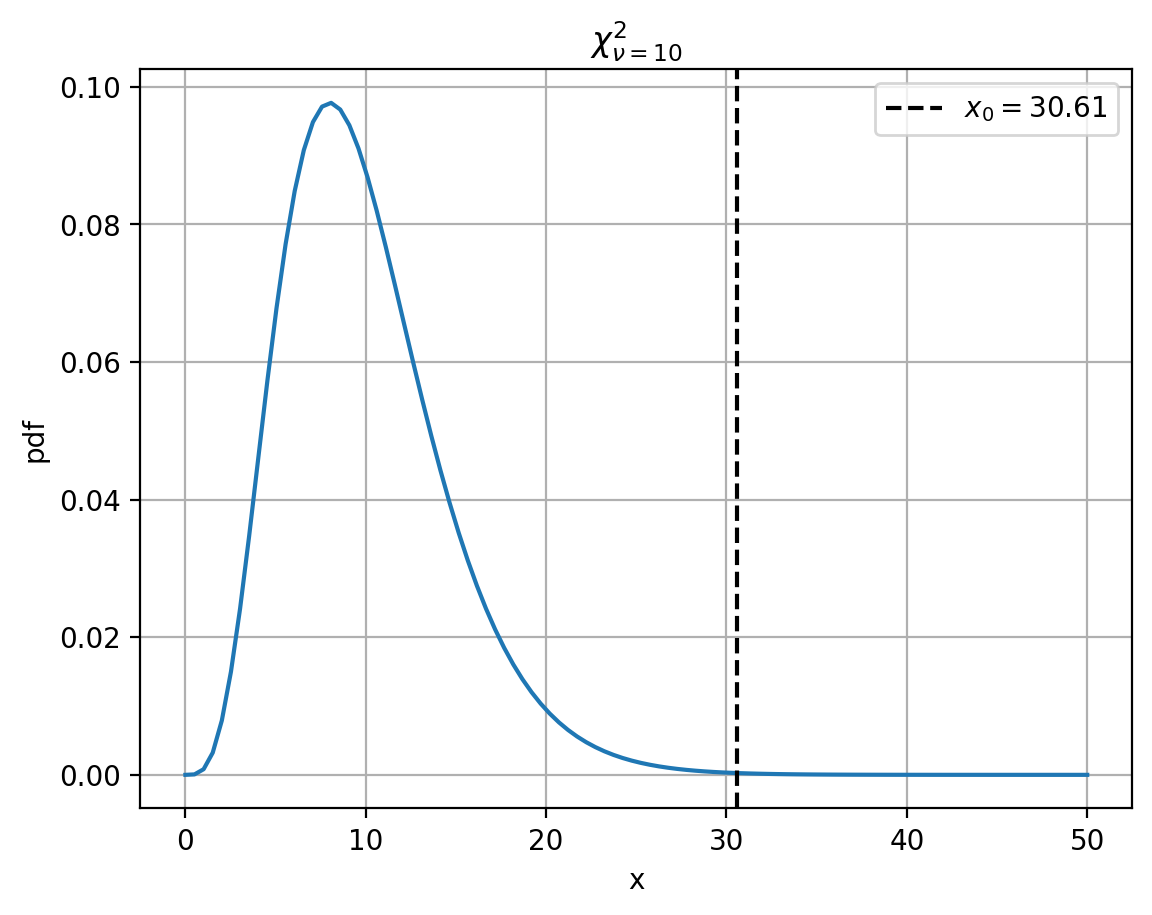

<IPython.core.display.Math object>

In [4]:
x0 = 30.61
df = 10
dist = chi2(df)
tail = dist.sf(x0)

# Plotting function
fig, ax = plt.subplots()
x = np.linspace(0, 50, 100)
ax.plot(x, dist.pdf(x))
ax.axvline(x=x0, ls='--', color='k', label=f'$x_0 = {x0}$')
#ax.fill_between(x[x < x0], 0, dist.pdf(x[x < x0]))
ax.set_title(r'$\chi^2_{\nu = 10}$')
ax.set_xlabel('x')
ax.set_ylabel('pdf')
ax.grid()
ax.legend()

fig.get_tight_layout()
plt.show()
display(Math('\\text{Área da cauda depois de 30.61: }' + f'{tail:.5f}'))

### 6.4)

A distribuição $F(\nu_1, \nu_2)$ definida por

$$ F = \frac{X / \nu_1}{Y /\nu_2},$$

onde $X$ e $Y$ são variáveis aleatórias de distribuições $\chi^2(\nu_1)$ e $\chi^2(\nu_2)$ respectivamente. Um exemplo prático para $X$ e $Y$ são as variâncias amostrais: para um conjunto de $n$ amostras, $(n -1) S^2/\sigma^2$ segue uma distribuição $\chi^2(n - 1)$. Assim, a razão

$$ \frac{S_1^2 / \sigma_1^2}{S_2^2 / \sigma_2^2} \sim F(n_1 - 1, n_2 - 1)$$


In [5]:
s1_squared = 16.65
n1 = 6
s2_squared = 5.0
n2 = 11

# Validate Gregory's calculation
assert np.allclose(0.5 * s1_squared / s2_squared, 1.665)

fval = 3.33
prob = f(n1 - 1, n2 - 1).sf(fval)
display(Math('\mathbb{P}(f \geq ' + f'{fval:.2f}) = {prob:.2f}'))

# Ensure that relabelling the samples does not change the calculation
assert np.allclose(prob, f(n2 - 1, n1 - 1).cdf(1. / fval))

<IPython.core.display.Math object>

## Questão 2

### 7.2)

Visualizamos as amostras para os dois pontos de análise do rio em questão:

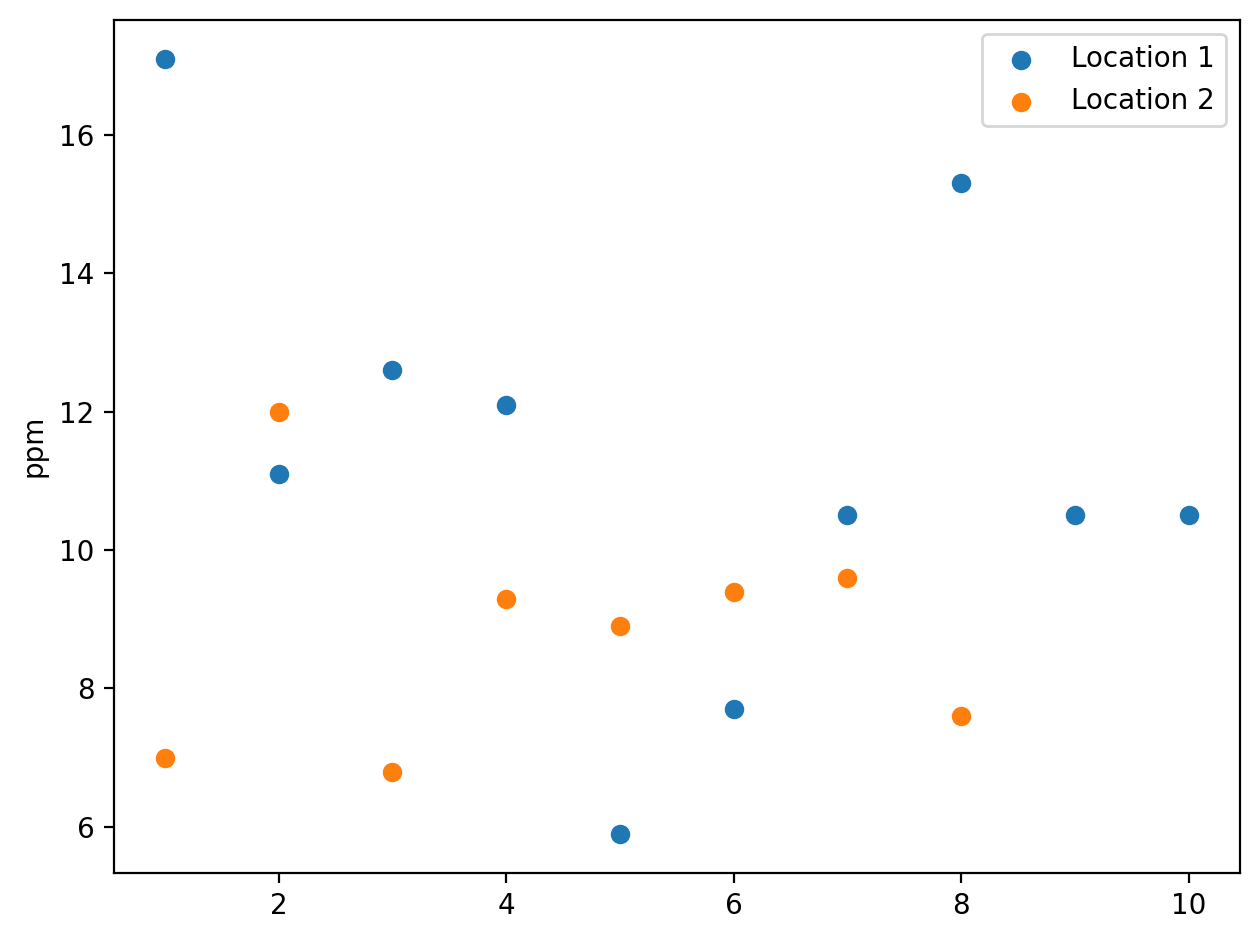

In [6]:
filename = '../data/pb3/q2rivers.csv'
df = pd.read_csv(filename, index_col=None)
fig, (ax) = plt.subplots()
data_1 = df.iloc[:, 0].dropna()
data_2 = df.iloc[:, 1].dropna()
ax.scatter(np.arange(1, data_1.size + 1), data_1, label=data_1.name)
ax.scatter(np.arange(1, data_2.size + 1), data_2, label=data_2.name)
ax.set_ylabel('ppm')
ax.legend()
fig.tight_layout()
plt.show()


Calculamos as respectivas médias e variâncias amostrais:

In [7]:
sample1  = IIDSamples(data_1)
sample2 = IIDSamples(data_2)

# Sample mean
display(Math(f'\\overline{{X}}_1 = {sample1.sample_mean:.2f}'))
display(Math(f'\\overline{{X}}_2 = {sample2.sample_mean:.2f}'))

# Sample variance
display(Math(f'S^2_1 = {sample1.sample_variance:.2f}'))
display(Math(f'S^2_2 = {sample2.sample_variance:.2f}'))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Calculamos o intervalo de confiança a 95% da média e da variância da primeira amostra:

In [8]:
alpha = 0.95
low, high = sample1.mean_confidence_interval(alpha)
display(Math(f'{low:.2f} < \\mu < {high:.2f}'))

low, high = sample1.variance_confidence_interval(alpha)
display(Math(f'{low:.2f} < \\sigma^2 < {high:.2f}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Fazemos o mesmo para a segunda amostra:

In [9]:
low, high = sample2.mean_confidence_interval(alpha)
display(Math(f'{low:.2f} < \\mu < {high:.2f}'))

low, high = sample2.variance_confidence_interval(alpha)
display(Math(f'{low:.2f} < \\sigma^2 < {high:.2f}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Vamos analisar as variâncias das amostras. Calculamos a p-valor da hipótese nula $H: \sigma_2^2 / \sigma_1^2 = 1$. Para tal, usamos a estatística

$$\frac{S_1^2 / \sigma_1^2}{S_2^2 / \sigma_2^2}$$

que segue uma distribuição $F(n_1 - 1, n_2 - 2)$. Implementamos na função abaixo:

In [10]:
def ratio_of_variances(sample1: IIDSamples, sample2: IIDSamples):
    n1, n2 = sample1.n, sample2.n
    s1 = sample1.sample_variance
    s2 = sample2.sample_variance
    ratio = s1 / s2
    normalized_ratio = max(ratio, 1. / ratio)
    dist = f(n1 - 1, n2 - 1)
    two_sided_p_value = 1.0 - (dist.sf(1. / normalized_ratio) - dist.sf(normalized_ratio))
    return ratio, two_sided_p_value

In [11]:
ratio, p_value = ratio_of_variances(sample1, sample2)
print(f"""
F-statistic: {ratio:.2f}
Two-sided p-value: {p_value:.4f}
""")


F-statistic: 3.70
Two-sided p-value: 0.0852



Partimos para os testes de hipótese sobre a média das amostras. Escolhemos a hipótese nula como $H_0: \mu_1 = \mu_2$. A estatística que usamos é 

$$ T = \frac{\overline{X}_1 - \overline{X}_2 - (\mu_1 - \mu_2)}{S_p} $$

definida na Eq. (7.10) do livro do Gregory, que segue uma distribuição de t-Student, cujo grau de liberdade $\nu$ depende do denominador $S_p$. Implementamos abaixo a função para calcular essa estatística e o p-valor associado.

In [12]:
def difference_of_means(sample1: IIDSamples, sample2: IIDSamples, equal_variance=False):
    n1, n2 = sample1.n, sample2.n
    s1 = sample1.sample_variance
    s2 = sample2.sample_variance
    if equal_variance:
        nu = n1 + n2 - 2
        # Gregory Eq. 6.61
        sp = np.sqrt(
            ((n1 -1.0) * s1 + (n2 -1.0) * s2) 
            * (1. / n1 + 1. / n2)
            / nu
        )
    else:
        # Gregory Eq. 6.63
        sp_squared = s1 / n1 + s2 / n2
        sp = np.sqrt(sp_squared)
        # Gregory Eq. 6.63
        nu = (
            sp_squared ** 2 
            / ((s1 / n1) ** 2 / (n1 - 1.0) + (s2 / n2) ** 2 / (n2 - 1.0))
        )
    known_means = sample1.known_mu and sample2.known_mu
    diff_mean = sample1.mu - sample2.mu if known_means else 0.
    t_statistic = (sample1.sample_mean - sample2.sample_mean - diff_mean) / sp
    dist = t(nu)
    one_sided_p_value = dist.sf(t_statistic)
    two_sided_p_value = 1.0 - (dist.sf(-t_statistic) - dist.sf(t_statistic))
    return t_statistic, nu, one_sided_p_value, two_sided_p_value


Assumimos em um primeiro momento que as variâncias das amostras são iguais, $\sigma_1^2 = \sigma_2^2$.

In [13]:
stat, nu, onep, twop = difference_of_means(sample1, sample2, equal_variance=True)
print(f"""
T-statistic: {stat:.2f}
Degrees of freedom: {nu:.1f}
One-sided p-value: {onep:.4f}
Two-sided p-value: {twop:.4f}
Confidence in rejecting null hypothesis: {1. - twop:.4f}
""")


T-statistic: 1.96
Degrees of freedom: 16.0
One-sided p-value: 0.0339
Two-sided p-value: 0.0677
Confidence in rejecting null hypothesis: 0.9323



Concluímos que podemos descartar a hipótese nula com uma confiança de 93,2%. 
Abaixo relaxamos a hipótese e utilizamos a estátistica com base nas Eqs. 7.11 e 7.12 do Gregory.

In [14]:
stat, nu, onep, twop = difference_of_means(sample1, sample2, equal_variance=False)
print(f"""
T-statistic: {stat:.2f}
Degrees of freedom: {nu:.1f}
One-sided p-value: {onep:.4f}
Two-sided p-value: {twop:.4f}
Confidence in rejecting null hypothesis: {1. - twop:.4f}
""")


T-statistic: 2.10
Degrees of freedom: 14.0
One-sided p-value: 0.0273
Two-sided p-value: 0.0546
Confidence in rejecting null hypothesis: 0.9454



Sem a hipótese de variâncias iguais, descartamos a hipótese nula com uma confiança de 94,5%.

## Questão 3

Usamos a média amostral $\bar{X}$ como estimador não enviesado do parâmetro $\lambda$ da distribuição de Poisson. Na célula abaixo, visualizamos os dados sobrepostos à distribuição $P(\lambda)$.

Inferred mean of Poisson distribution: 4.06


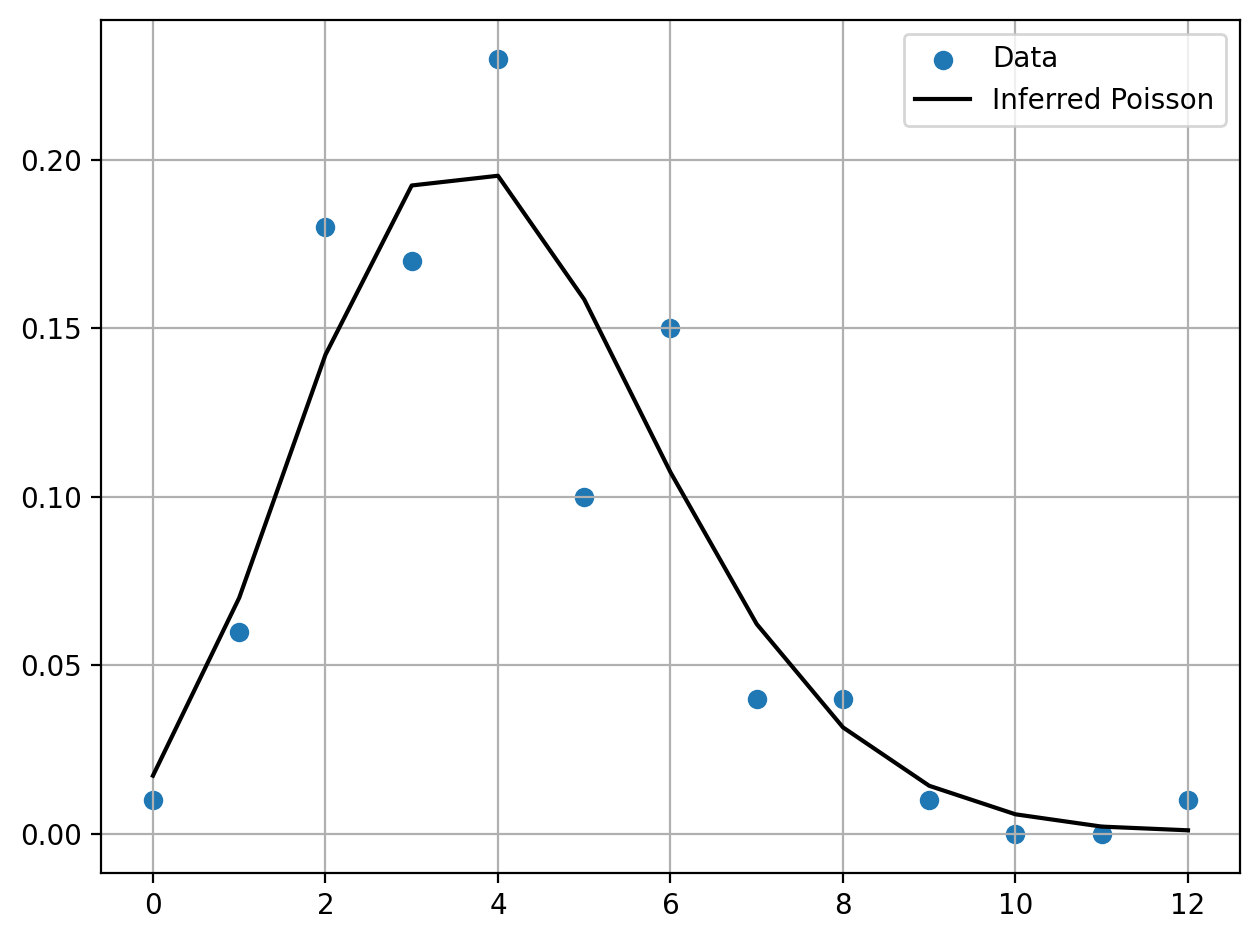

,Actual number,Expected number,Partial Chi squared
0,1,1.724902,0.304645
1,6,7.003102,0.143681
2,18,14.216297,1.007042
3,17,19.239388,0.260656
4,23,19.527979,0.617316
5,10,15.856719,2.163194
6,15,10.729713,1.699519
7,4,6.223234,0.794244
8,4,3.158291,0.224322
9,1,1.424740,0.126623


In [15]:
obs = np.asarray([1, 6, 18, 17, 23, 10, 15, 4, 4, 1, 0, 0, 1])
bins = np.arange(obs.size, dtype=int)
nobs = np.sum(obs)
assert bins.size == obs.size

dist_mean = np.average(bins, weights=obs)
print(f'Inferred mean of Poisson distribution: {dist_mean:.2f}')
dist = poisson(dist_mean)
fig, ax = plt.subplots()
p_observed = obs / nobs
p_theoretical = np.concatenate((dist.pmf(bins[:-1]), dist.pmf(bins[-1:]) + dist.sf(bins[-1:])))
#p_theoretical = dist.pmf(bins)
ax.scatter(bins, p_observed, label='Data')
ax.plot(bins, p_theoretical, color='k', label='Inferred Poisson')
ax.grid()
ax.legend()
fig.tight_layout()
plt.show()

table = pd.DataFrame({'Actual number': obs, 'Expected number': p_theoretical * nobs }, index=bins)
table['Partial Chi squared'] = (obs - p_theoretical * nobs) ** 2 / p_theoretical / nobs
display(HTML(table.to_html()))

Calculamos a estatística de goodness of fit

$$ \sum_i^{k} \frac{(N_i - Np_i)^2}{Np_i} \sim \chi^2(k-2)$$

para as $k$ classes que correspondem à contagem de medidas de radiação. Os dois graus de liberdade removidos vêm da estimativa amostral de $\lambda$ e do vínculo 

$$\sum_i N_i = N$$

In [16]:
def pearson_goodness_of_fit(bins, obs, dist, dof=0):
    n = np.sum(obs)
    pbin = np.concatenate((dist.pmf(bins[:-1]), dist.pmf(bins[-1:]) + dist.sf(bins[-1:])))
    npbin = n * pbin
    statistic = np.sum((obs - npbin) ** 2 / npbin)
    nu = len(bins) - dof
    return statistic, nu, chi2.sf(statistic, nu)

In [17]:
statistic, nu, p_value = pearson_goodness_of_fit(bins, obs, dist, dof=2)
print(f"""
Pearson goodness-of-fit test statistic: {statistic:.2f}
Degrees of freedom: {nu}
P-value: {p_value:.4f}
""")



Pearson goodness-of-fit test statistic: 15.88
Degrees of freedom: 11
P-value: 0.1456



Com um p-valor de ~15%, não podemos descartar a hipótese nula de que a distribuição de contagem de radiação é Poisson.

## Questão 4

Visualizamos os dados:

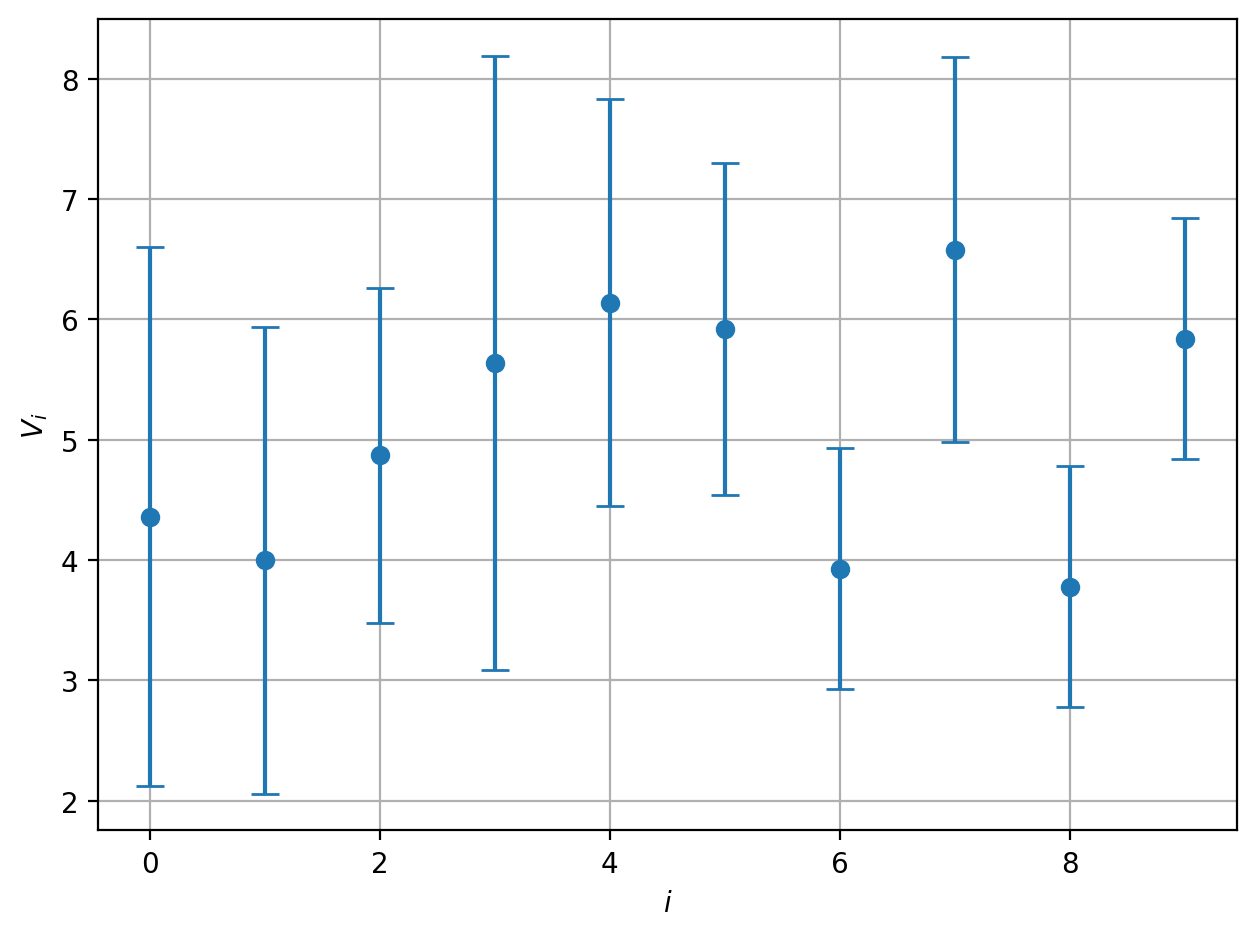

In [18]:
v = np.array([4.36, 4.00, 4.87, 5.64, 6.14, 5.92, 3.93, 6.58, 3.78, 5.84])
sigma = np.array([2.24, 1.94, 1.39, 2.55, 1.69, 1.38, 1.00, 1.60, 1.00, 1.00])

fig, ax = plt.subplots()
ax.errorbar(np.arange(v.size), v, yerr=sigma, fmt='o', capsize=5)
ax.set_xlabel('$i$')
ax.set_ylabel('$V_i$')
ax.grid()
fig.tight_layout()
plt.show()

Calculamos a probabilidade $\mathbb{P}(\mu|D,I)$ usando o passo-a-passo da seção 9.2.2 do livro do Gregory, usando as quantidades

$$ w_i = \frac{1}{\sigma_i^2},$$

$$ \bar{d} = \frac{ \sum_i w_i d_i}{\sum_i w_i},$$
$$ \sigma_T^2 = \left(\sum_i w_i \right)^{-1}.$$

In [19]:
def prob_mu_unequal_sigma(mu, d, sigma):
    weights = 1. / sigma ** 2
    d_bar = np.average(d, weights=weights)
    sigma_tot = np.sqrt(1. / np.sum(weights))
    prob = norm.pdf(mu, loc=d_bar, scale=sigma_tot)
    return normalize(prob, mu), d_bar, sigma_tot

Visualizamos a distribuição $\mathbb{P}(\mu|D,I)$ assim como o intervalo de confiança a $1\sigma$ para $\mu$.

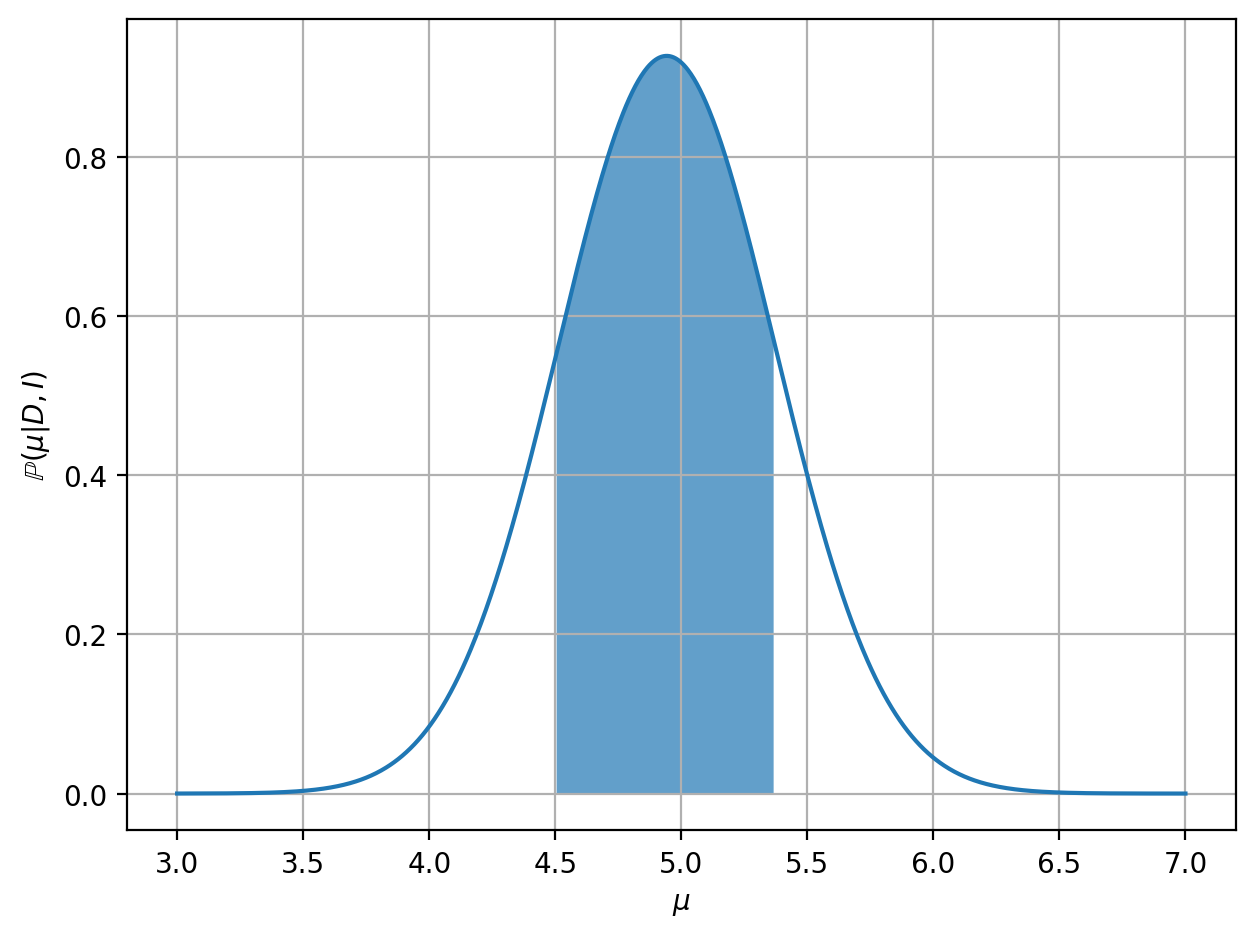

In [20]:
n = 1000
mu = np.linspace(3., 7., n)
prob, d_bar, sigma_tot = prob_mu_unequal_sigma(mu, v, sigma)

median, low, high = hdi(prob, mu, 0.683)

fig, ax = plt.subplots()
ax.plot(mu, prob)
ax.fill_between(mu[low:high], 0., prob[low:high], alpha=0.7)
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\mathbb{P}(\mu|D,I)$')
ax.grid()
fig.tight_layout()
plt.show()

In [21]:
display(Math(f'{mu[low]:.2f} < \mu < {mu[high]:.2f} \\text{{ at 1}}\sigma'))
low_theo, high_theo = d_bar - sigma_tot, d_bar + sigma_tot
display(Math(f'\\bar{{d}} - \sigma_T = {low_theo:.2f}, \, \\bar{{d}} + \sigma_T = {high_theo:.2f}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Como a distribuição posteriori de $\mu$ é gaussiana de média $\bar{d}$ e variância $\sigma_T^2$, o intervalo de confiança a $1\sigma$ será por definição $[\bar{{d}} - \sigma_T, \bar{{d}} + \sigma_T]$, conforme mostra a célula acima. 

Essa situação muda se a priori imposta a $\mu$ for restritiva o suficiente de forma que exista uma probabilidade não negligencíavel fora do seu suporte. Na célula abaixo, restringimos o intervalo da priori para $\mu \in  [4.6, 5.4]$ e observamos como essa mudança afeta o intervalo de confiança calculado anteriormente.

In [22]:
dist = norm(loc=d_bar, scale=sigma_tot)
p_outside_wide_prior = dist.cdf(3.) + dist.sf(7.)
p_outside_narrow_prior = dist.cdf(4.6) + dist.sf(5.4)
print(f'Probabilidade fora do suporte da priori larga: {p_outside_wide_prior:.2e}')
print(f'Probabilidade fora do suporte da priori estreita: {p_outside_narrow_prior:.2e}')

Probabilidade fora do suporte da priori larga: 4.04e-06
Probabilidade fora do suporte da priori estreita: 3.57e-01


<IPython.core.display.Math object>

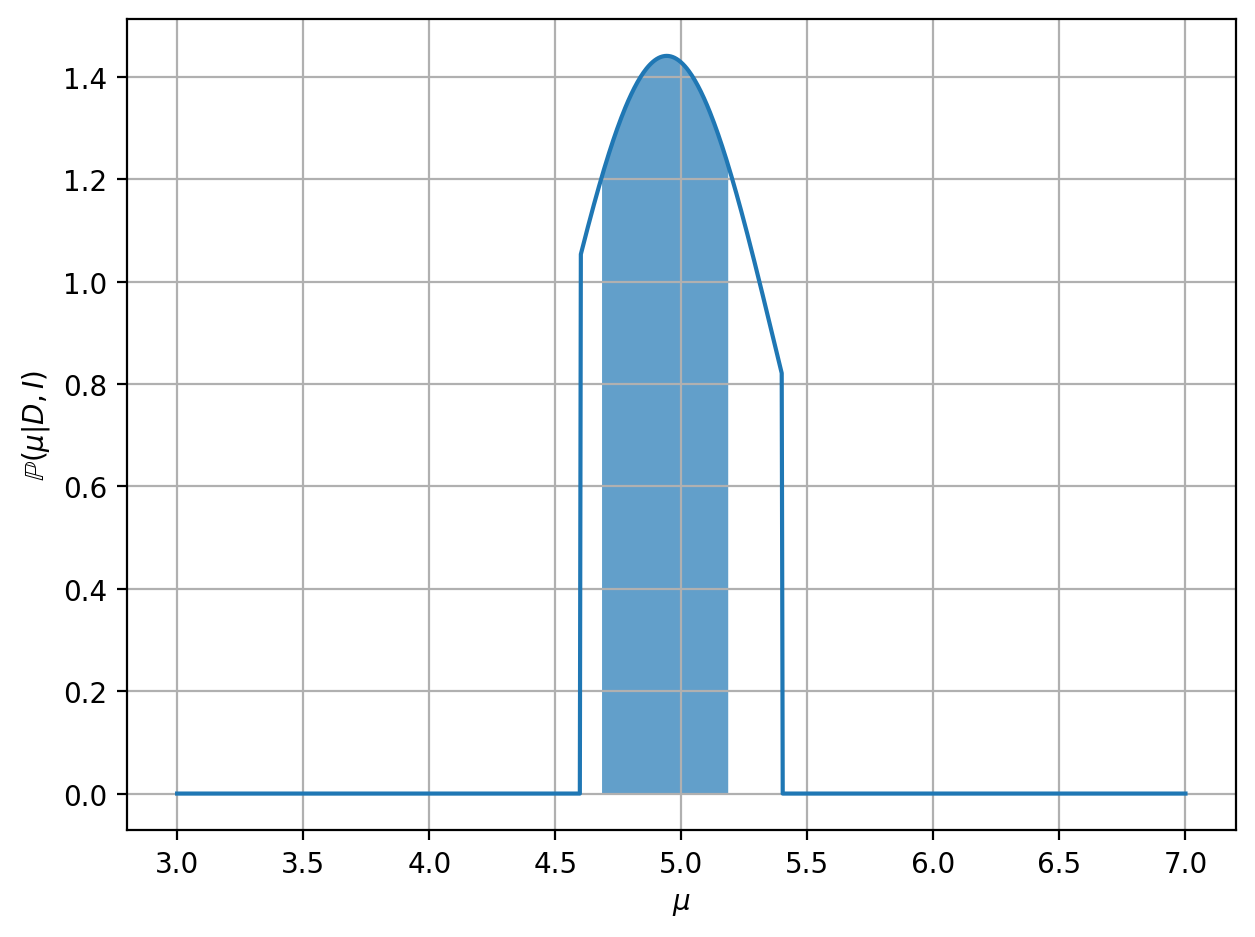

In [23]:
prob[mu < 4.6] = 0.
prob[mu >= 5.4] = 0.
prob = normalize(prob, mu)

median, low, high = hdi(prob, mu, 0.683)
display(Math(f'{mu[low]:.2f} < \mu < {mu[high]:.2f} \\text{{ at 1}}\sigma'))

fig, ax = plt.subplots()
ax.plot(mu, prob)
ax.fill_between(mu[low:high], 0., prob[low:high], alpha=0.7)
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\mathbb{P}(\mu|D,I)$')
ax.grid()
fig.tight_layout()
plt.show()

## Questão 5


Observa-se qualitativamente a ação do Teorema do Limite Central: a medida que $n$ aumenta, as curvas parecem convergir para uma distribuição com uma determinada média, e com uma variância progressivamente menor.

In [25]:
n = 100
mu_x, sigma_x = 5, 2
sigma_y = 4
sigma_w = 2
loc_w, scale_w = 0, 50

x = jnp.linspace(-10, 10, n)
y = jnp.linspace(-10, 4, n)
rv_w = norm(loc_w, scale_w)

def support_in_q(ppf, alpha, n):
    """Return array with range matching the support of the alpha% HDI"""
    q = 1 - alpha
    a, b = ppf([0.5 * q, 1 - 0.5 * q])
    low, high = min(a, b), max(a, b)
    return jnp.linspace(low, high, n)

w = support_in_q(rv_w.ppf, 0.683, n) # 95% probability

X, Y, W = jnp.meshgrid(x, y, w, indexing='ij', sparse=True)

Implementamos as distribuições com funções nativas de `jax.numpy` para usufruir do *automatic differentiation*, que será importante para calcular a matriz de Fisher.

In [26]:
def loglike(xx, yy, ww):
    return (
        -0.5 * ((xx - mu_x) / sigma_x) ** 2
        -0.5 * ((yy + 0.5 * yy ** 2 + 0.3 * xx ** 2 + ww) / sigma_y) ** 2
        -0.5 * (ww / sigma_w) ** 2
        + jnp.log(3. + ww ** 2)
    )

def log_prior(xx, yy, ww):
    return -jnp.log(x[-1] - x[0]) -jnp.log(y[-1] - y[0]) - norm_logpdf(ww, loc_w, scale_w)

def log_posterior(xx, yy, ww):
    return loglike(xx, yy, ww) + log_prior(xx, yy, ww)

def posterior(X, Y, W):
    _log_posterior = log_posterior(X, Y, W)
    posterior = jnp.exp(_log_posterior)
    return posterior

Calculando a posteriori para a grid:

In [28]:
def nd_normalize(mesh, arrs, axes=None):
    """Normalize an N-dimensional mesh over arbitrary axes"""
    prob = mesh
    _axes = np.asarray(axes, dtype=int)[::-1] if axes is not None else reversed(range(len(arrs)))
    for axis in _axes:
        prob = jnp.trapezoid(prob, x=arrs[axis], axis=axis)
    return prob

arrs = [x, y, w]
prob = posterior(X, Y, W)
evidence = nd_normalize(prob, arrs)
prob /= evidence

Na célula abaixo, encontramos os parâmetros de best-fit. Usamos o valor máximo da log-posteriori sobre a malha como um chute inicial para um algoritmo mais robusto implementado em `scipy.optimize.minimize`. Aqui já usufruimos da diferenciação automática do `jax` ao calcular o jacobiano para acelerar o otimizador.

In [36]:
def best_fit(mesh):
    idxs = np.unravel_index(np.argmax(mesh, axis=None), mesh.shape)
    def fit(*arrs):
        return np.asarray([arr[idxs] for arr in arrs])
    return fit

bestfit = best_fit(prob)
x0 = bestfit(X, Y, W)
print(f'First guess: {x0}')

def log_prob(x):
    return log_posterior(x[0], x[1], x[2])

def mlog_prob(x):
    return -log_prob(x)

jac = jacfwd(mlog_prob)
optimizer  = minimize(mlog_prob, x0, jac=jac, tol=1e-6)
print(f'Optimized result: {optimizer.x}')

First guess: [ 3.939394   -0.94949496 -2.5268738 ]
Optimized result: [ 3.98558655 -1.00021319 -2.56917109]


Na célula abaixo, implementamos um algoritmo simples para calcular as regiões de confiança, aproximando as integrais multidimesionais como

$$ \iint f(x,y) dx dy \simeq \sum_{ij} f(x_i, y_j) \Delta x \Delta y.$$

Definimos

$$ z(\alpha) = \text{Inf} \left \{ z \Bigg| \sum_{ij} f(x_i, y_j) \Theta \left[f(x_i, y_j) > z\right] \Delta x \Delta y > \alpha \right \},$$

onde $\Theta$ é a função de Heaviside e $f(x,y) \equiv \mathbb{P}(x,y|I)$. Dessa maneira, $z(\alpha)$ deve corresponder (aproximadamente) à curva de nível de $f$ correspondente à região de confiança $\alpha$.

Implementamos essa função somando as células em ordem decrescente de probabilidade. Os valores de $z(\alpha)$ são usados diretamente na função `axes.Axes.contour` do `matplotlib`, que calcula os contornos associados automaticamente. Usamos $\alpha \in {0.683, 0.954, 0.9973}$.

In [37]:
def credible_region_boundary(prob: np.ndarray, cell_area, alpha):
    prob_flat = prob.flatten().sort()[::-1] # Reversed
    cumul_prob = np.cumsum(prob_flat)
    i = np.searchsorted(cell_area * cumul_prob, alpha)
    return prob_flat[i]

def plot_credible_regions(ax, arrs, levels, labels, **kwargs):
    _levels = levels.tolist()
    contours = ax.contour(*arrs, levels=_levels, **kwargs)
    ax.clabel(contours, levels=_levels, fmt=dict(zip(_levels, labels)))

Caso 1: Fixamos os parâmetros nos seus respectivos valores de best-fit.

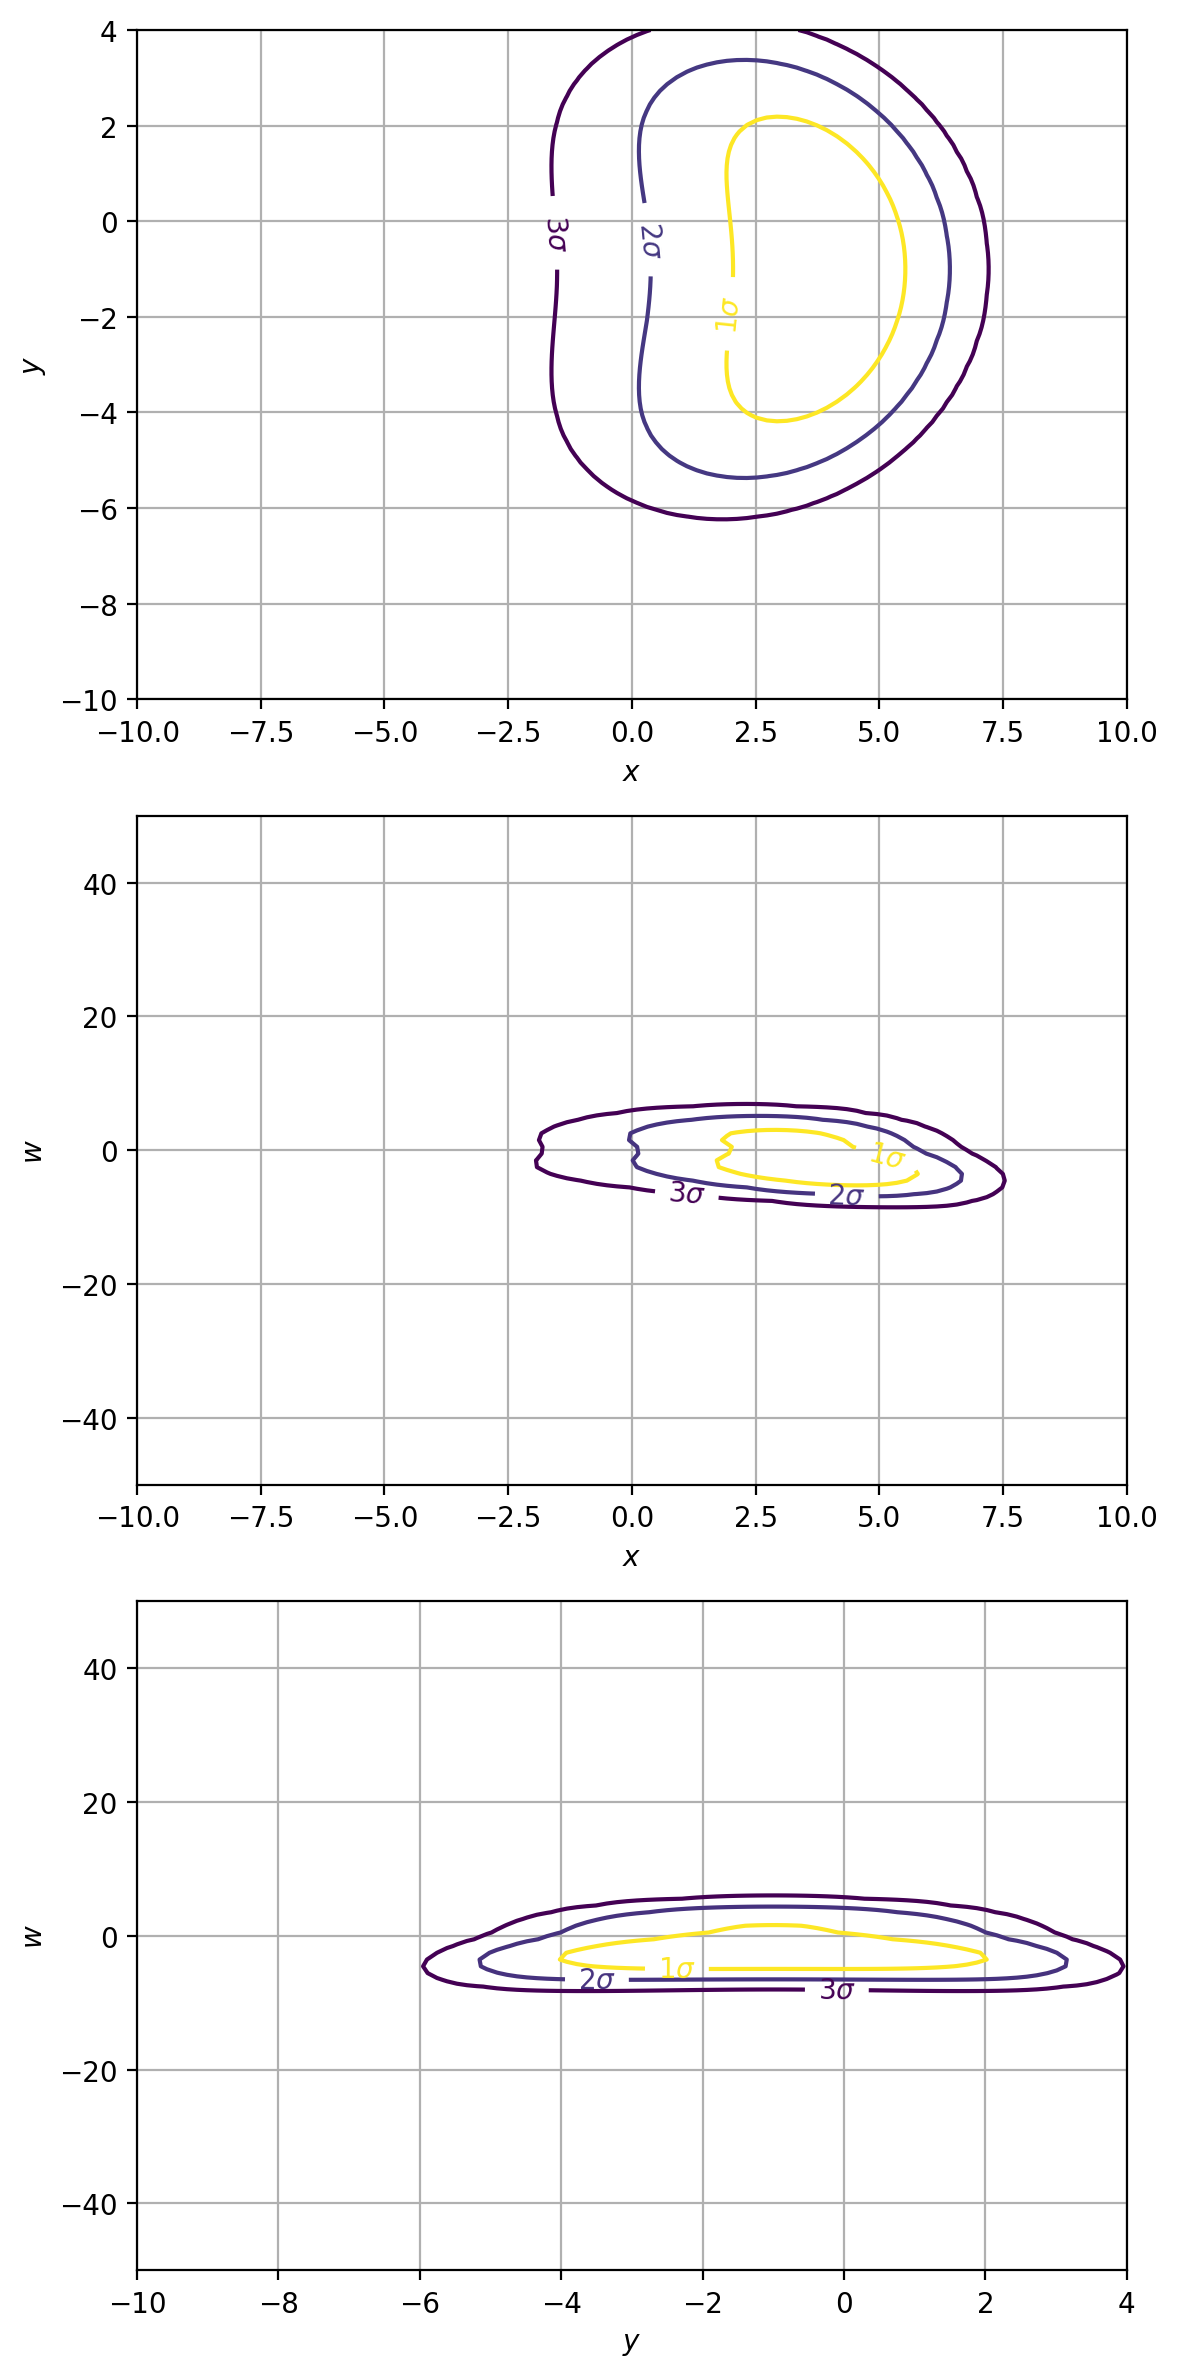

In [38]:
# Plotting
fig, (ax_xy, ax_xw, ax_yw) = plt.subplots(3, 1, figsize=(6, 12))

x0, y0, w0 = optimizer.x

delta_x, delta_y, delta_w = x[1] - x[0], y[1] - y[0], w[1] - w[0]
alpha = list(reversed([0.683, 0.954, 0.9973]))
labels = list(reversed([r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']))

xx, yy = np.meshgrid(x, y, indexing='ij')
cell_area = delta_x * delta_y
zz = posterior(xx, yy, w0)
zz /= (np.sum(zz) * cell_area)
levels = credible_region_boundary(zz, cell_area, alpha=alpha)
plot_credible_regions(ax_xy, [xx, yy, zz], levels, labels, cmap='viridis')
ax_xy.set_xlabel('$x$')
ax_xy.set_ylabel('$y$')
ax_xy.grid()

xx, ww = np.meshgrid(x, w, indexing='ij')
cell_area = delta_x * delta_w
zz = posterior(xx, y0, ww)
zz /= (np.sum(zz) * cell_area)
levels = credible_region_boundary(zz, cell_area, alpha=alpha)
plot_credible_regions(ax_xw, [xx, ww, zz], levels, labels, cmap='viridis')
ax_xw.set_xlabel('$x$')
ax_xw.set_ylabel('$w$')
ax_xw.grid()

yy, ww = np.meshgrid(y, w, indexing='ij')
cell_area = delta_y * delta_w
zz = posterior(x0, yy, ww)
zz /= (np.sum(zz) * cell_area)
levels = credible_region_boundary(zz, cell_area, alpha=alpha)
plot_credible_regions(ax_yw, [yy, ww, zz], levels, labels, cmap='viridis')
ax_yw.set_xlabel('$y$')
ax_yw.set_ylabel('$w$')
ax_yw.grid()

fig.tight_layout()
plt.show()

Caso 2: marginalizando sobre o terceiro parâmetro.

In [39]:
marginals = {
    'xy': nd_normalize(prob, arrs, axes=[-1]),
    'xw': nd_normalize(prob, arrs, axes=[1]),
    'yw': nd_normalize(prob, arrs, axes=[0])
}

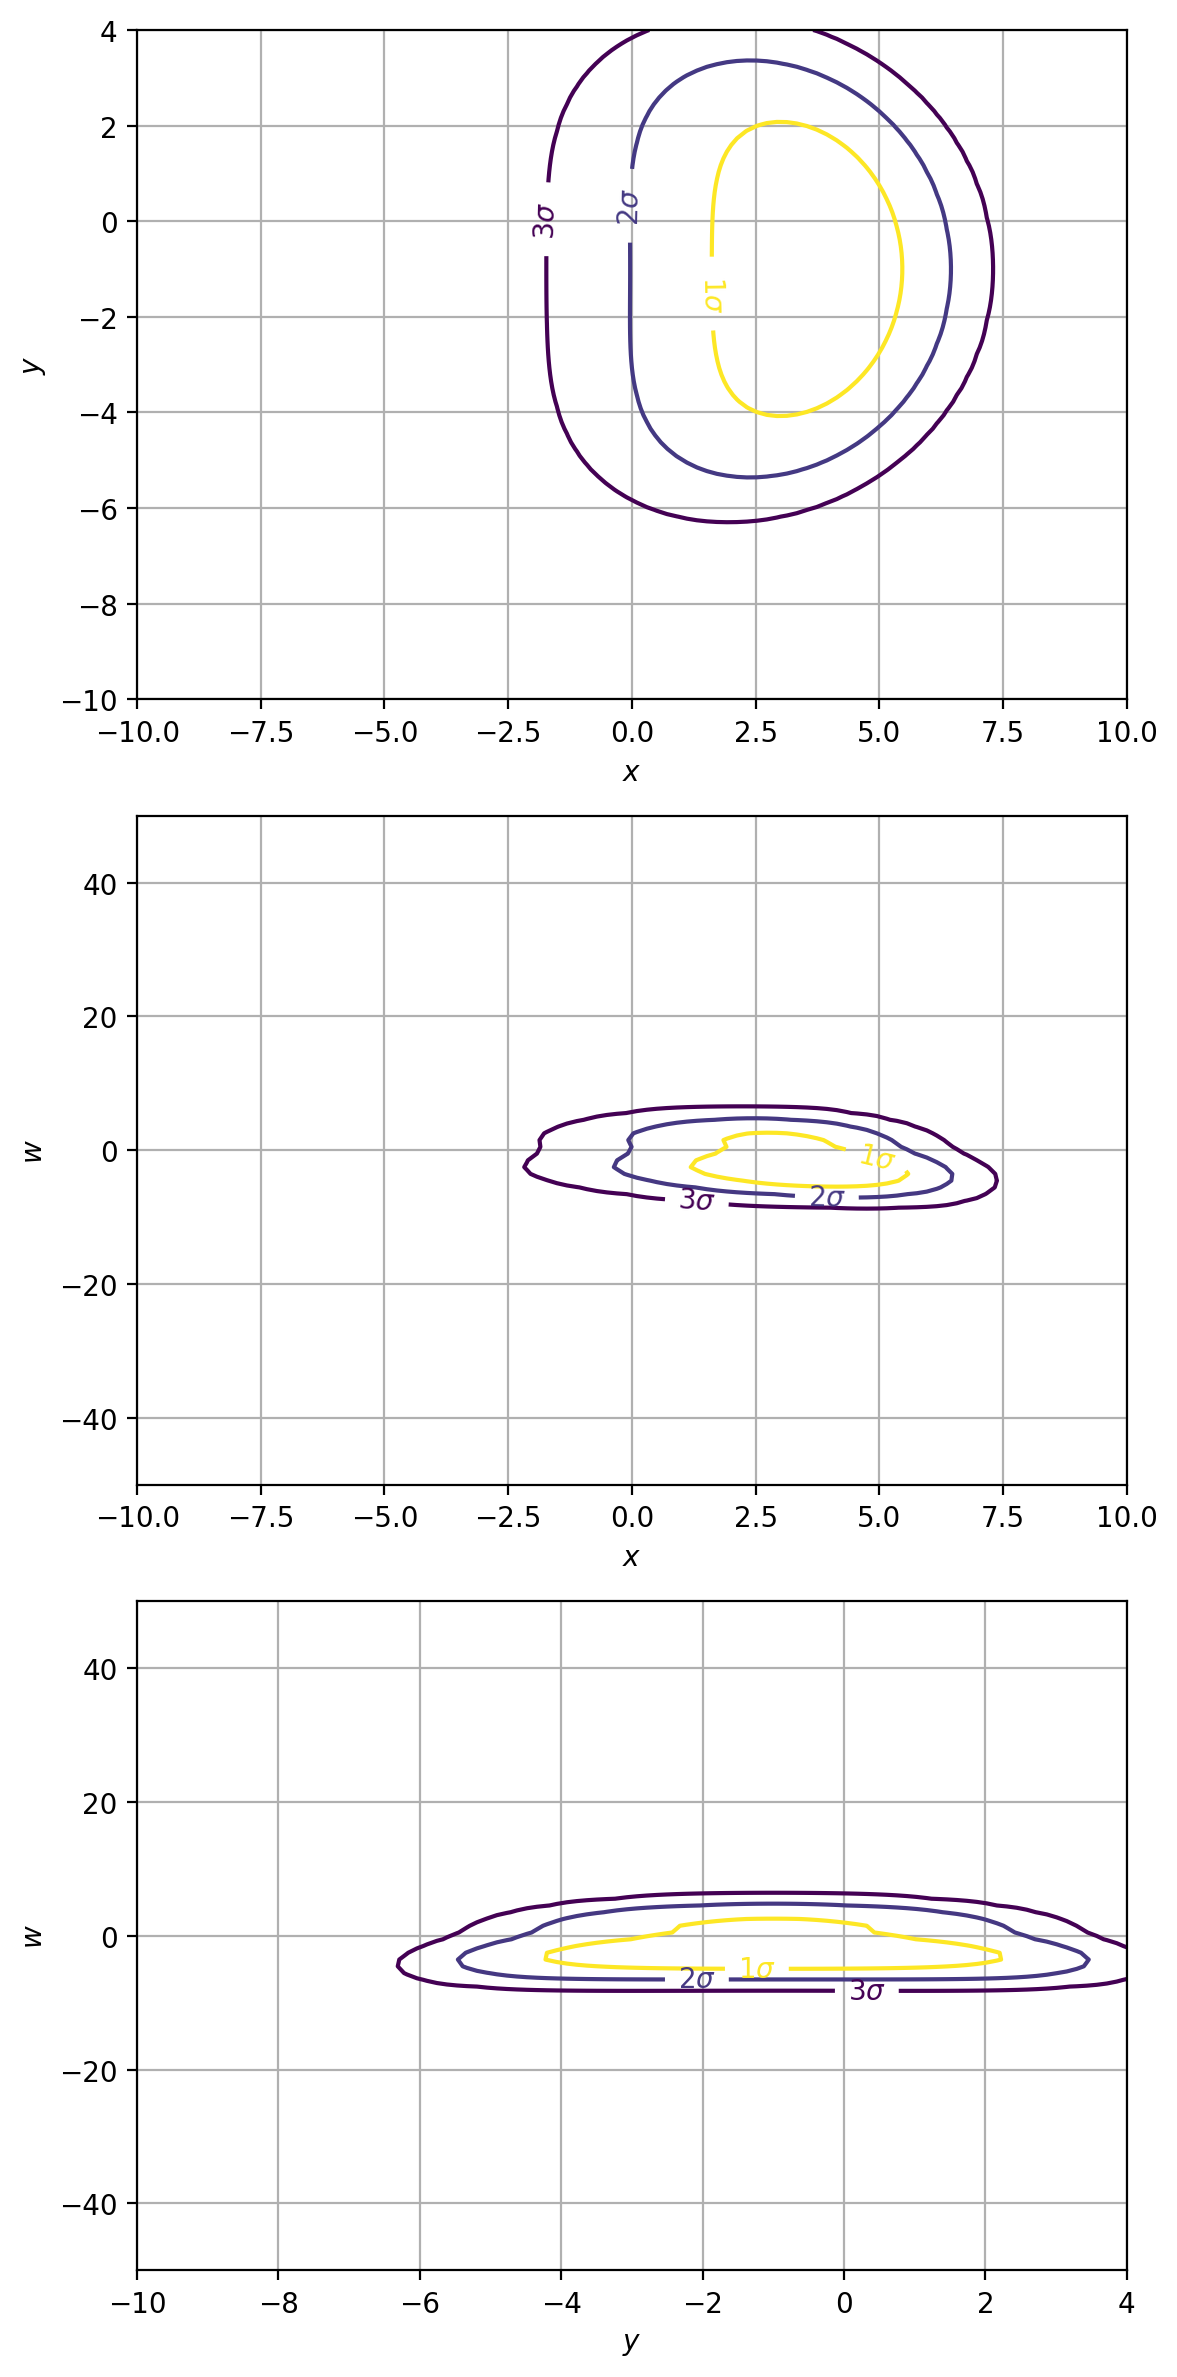

In [40]:
# Plotting
fig, (ax_xy, ax_xw, ax_yw) = plt.subplots(3, 1, figsize=(6, 12))

xx, yy = np.meshgrid(x, y, indexing='ij')
cell_area = delta_x * delta_y
zz = marginals['xy']
levels = credible_region_boundary(zz, cell_area, alpha=alpha)
plot_credible_regions(ax_xy, [xx, yy, zz], levels, labels, cmap='viridis')
ax_xy.set_xlabel('$x$')
ax_xy.set_ylabel('$y$')
ax_xy.grid()

xx, ww = np.meshgrid(x, w, indexing='ij')
cell_area = delta_x * delta_w
zz = marginals['xw']
zz /= (np.sum(zz) * cell_area)
levels = credible_region_boundary(zz, cell_area, alpha=alpha)
plot_credible_regions(ax_xw, [xx, ww, zz], levels, labels, cmap='viridis')
ax_xw.set_xlabel('$x$')
ax_xw.set_ylabel('$w$')
ax_xw.grid()

yy, ww = np.meshgrid(y, w, indexing='ij')
cell_area = delta_y * delta_w
zz = marginals['yw']
zz /= (np.sum(zz) * cell_area)
levels = credible_region_boundary(zz, cell_area, alpha=alpha)
plot_credible_regions(ax_yw, [yy, ww, zz], levels, labels, cmap='viridis')
ax_yw.set_xlabel('$y$')
ax_yw.set_ylabel('$w$')
ax_yw.grid()

fig.tight_layout()
plt.show()

## Questão 6

Construindo a matriz de Fisher:

In [41]:
sigma_contour_coeff = {
    1: 1.51,
    2: 2.49,
    3: 3.44
}

def remove_column_row(matrix, i: int):
    j = i + 1
    return np.block([
                [matrix[:i, :i], matrix[:i, j:]],
                [matrix[j:, :i], matrix[j:, j:]]
    ])

class Fisher:
    def __init__(self, log_prob, params) -> None:
        self.log_prob = log_prob
        self._matrix = -hessian(self.log_prob)(params)

    def matrix(self, marginalize=[], maximize=[]):
        m = self._matrix
        for i in maximize:
            m = remove_column_row(m, i)
        cov = jnp.linalg.inv(m)
        for j in marginalize:
            cov = remove_column_row(cov, j)
        return jnp.linalg.inv(cov), cov
    
    def plot(self, ax, matrix, params, sigma: int, **kwargs):
        eigenvalues = np.linalg.eigvals(matrix)
        angle = 0.5 * np.arctan2(2 * matrix[1, 0], matrix[0, 0] ** 2 - matrix[1, 1] ** 2)
        angle = np.rad2deg(angle)
        axes = 2 * sigma_contour_coeff[sigma] * np.sqrt(np.abs(eigenvalues))
        ax.add_patch(Ellipse(params, axes[0], axes[1], angle=angle, **kwargs))


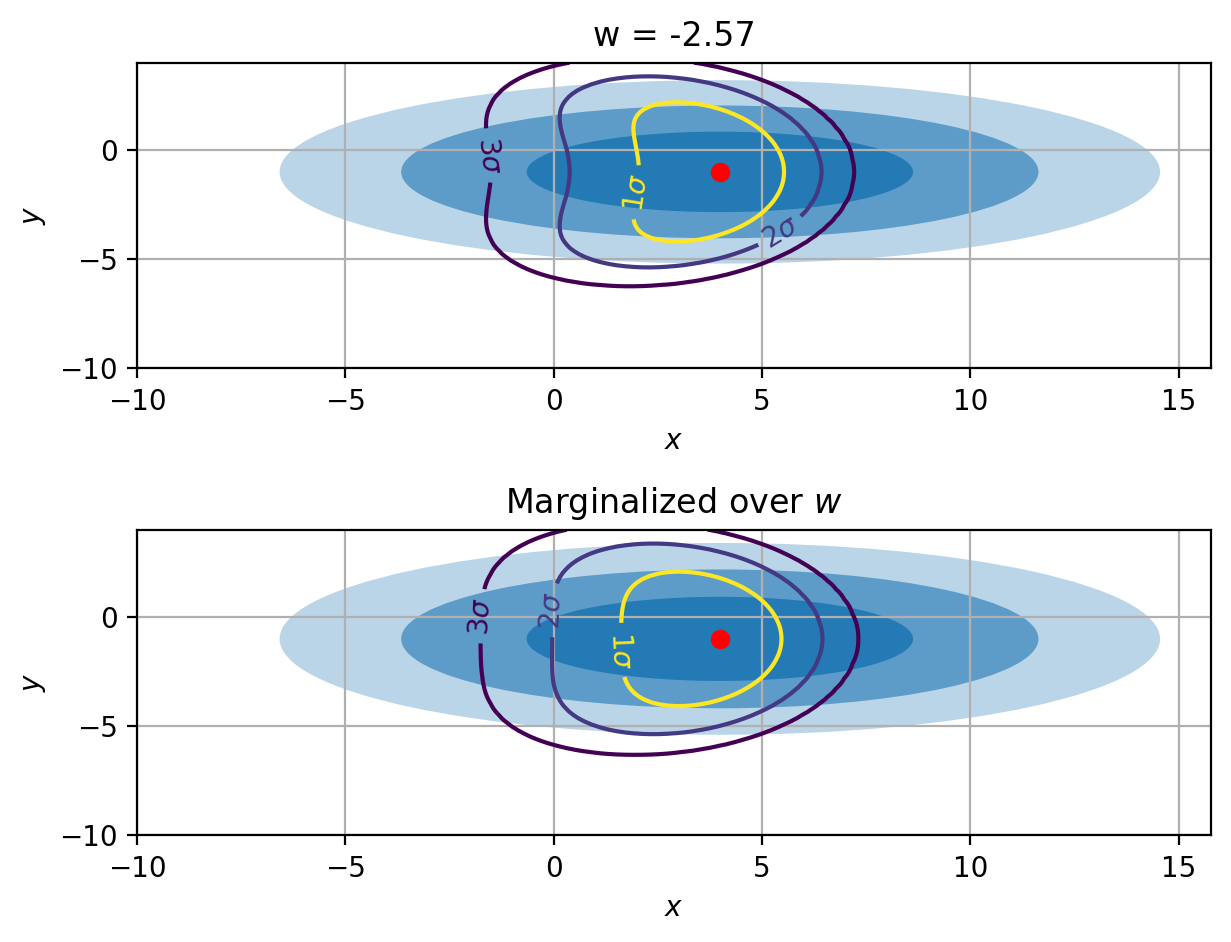

In [42]:
fisher = Fisher(log_prob, optimizer.x)
xy = np.stack((x0, y0))
fig, (ax1, ax2) = plt.subplots(2, 1)
sigma = (1, 2, 3)
alpha = (0.9, 0.6, 0.3)
q = list(reversed([0.683, 0.954, 0.9973]))

# Maximize w
xx, yy = np.meshgrid(x, y, indexing='ij')
cell_area = delta_x * delta_y
zz = posterior(xx, yy, w0)
zz /= (np.sum(zz) * cell_area)
levels = credible_region_boundary(zz, cell_area, alpha=q)
plot_credible_regions(ax1, [xx, yy, zz], levels, labels, cmap='viridis')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_title(f'w = {w0:.2f}')
ax1.grid()

fish, cov = fisher.matrix(maximize=[2])
for s, a in zip(sigma, alpha):
    fisher.plot(ax1, cov, xy, s, alpha=a)
ax1.scatter(xy[0], xy[1], color='red')

# Marginalize over w
xx, yy = np.meshgrid(x, y, indexing='ij')
cell_area = delta_x * delta_y
zz = marginals['xy']
zz /= (np.sum(zz) * cell_area)
levels = credible_region_boundary(zz, cell_area, alpha=q)
plot_credible_regions(ax2, [xx, yy, zz], levels, labels, cmap='viridis')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title('Marginalized over $w$')
ax2.grid()

fish, cov = fisher.matrix(marginalize=[2])
for s, a in zip(sigma, alpha):
    fisher.plot(ax2, cov, xy, s, alpha=a)
ax2.scatter(xy[0], xy[1], color='red')

fig.tight_layout()
plt.show()